###Importing Libraries

In [ ]:
!pip uninstall statsmodels
!pip install git+https://github.com/statsmodels/statsmodels.git

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime

!pip install verstack
from verstack.stratified_continuous_split import scsplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statistics import mean 
from sklearn.model_selection import RandomizedSearchCV

###Importing Data

In [149]:
#Read in Data
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/media_spend.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [107]:
df.head()

,Division,Calendar_Week,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
0,A,1/6/2018,392,422,408,349895.0107,73580,12072,682,59417
1,A,1/13/2018,787,904,110,506270.2176,11804,9499,853,56806
2,A,1/20/2018,81,970,742,430042.1538,52232,17048,759,48715
3,A,1/27/2018,25,575,65,417745.6658,78640,10207,942,72047
4,A,2/3/2018,565,284,295,408505.8012,40561,5834,658,56235


# Data Visualizations

Checking Sales Distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ff4ac7eb0>]],
      dtype=object)

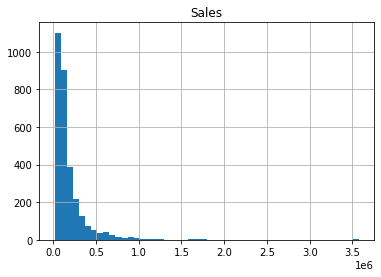

In [11]:
df.hist(column = ["Sales"], bins = 50)

We notice that the target variable data is quite imbalanced, as its data does not have a normal distribution. Thus, we need to find a strategy and models must be able to handle this imbalanced data.

### Scatterplot Series

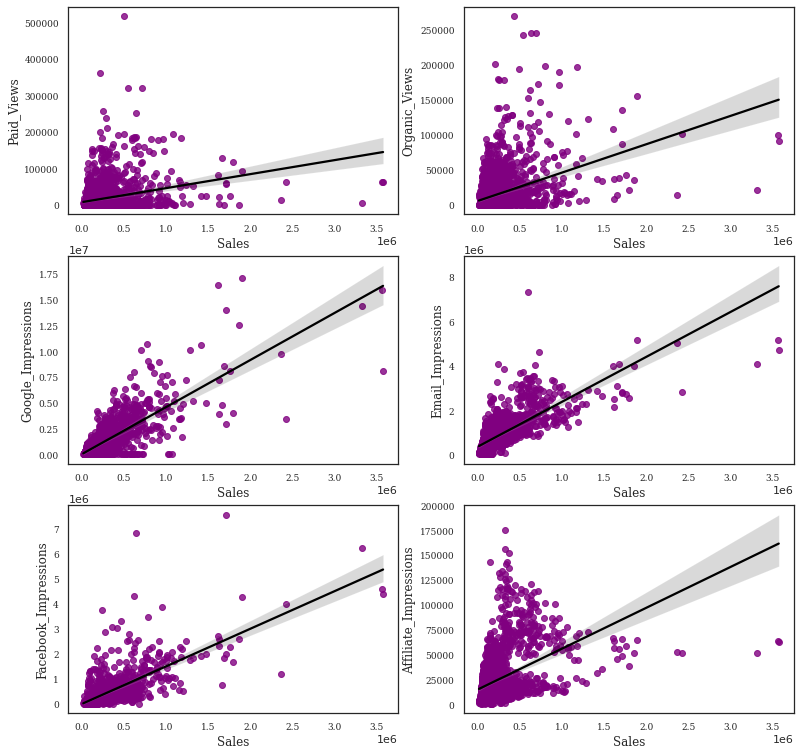

In [120]:
def creating_scatter(size, features, data):
    total_features = len(features)
    plt.figure(figsize=(13,13))

    for i in range(len(features)):

      plt.subplot(math.ceil(total_features/2), 2, i+1) 
      sns.regplot(x=data['Sales'], y=data[features[i]], scatter_kws={"color": "purple"}, line_kws={"color": "black"})
      plt.ylabel(features[i], fontsize = 12, fontname="serif")
      plt.xlabel('Sales', fontsize = 12, fontname="serif")
      plt.yticks(fontsize=9, fontname="serif")
      plt.xticks(fontsize=9, fontname="serif")
    #Save image
    plt.savefig("sales_scatter.png", bbox_inches='tight')

# Getting the name of all columns without the data type 'object' and 'datetime64' from dataframe
num_vars = df.loc[:, ~df.columns.isin(['Sales', 'Overall_Views'])].select_dtypes(exclude=['object', 'datetime64']).columns

# Creating distribution plots for each numerical column
creating_scatter((15,15), num_vars, df)

Based on the scatterplots, we notice that advertisement sales are most highly correlated with impressions, especially those from Google or Affiliate Impressions. On the other hand, they are less correlated with views.

### Sales per Region

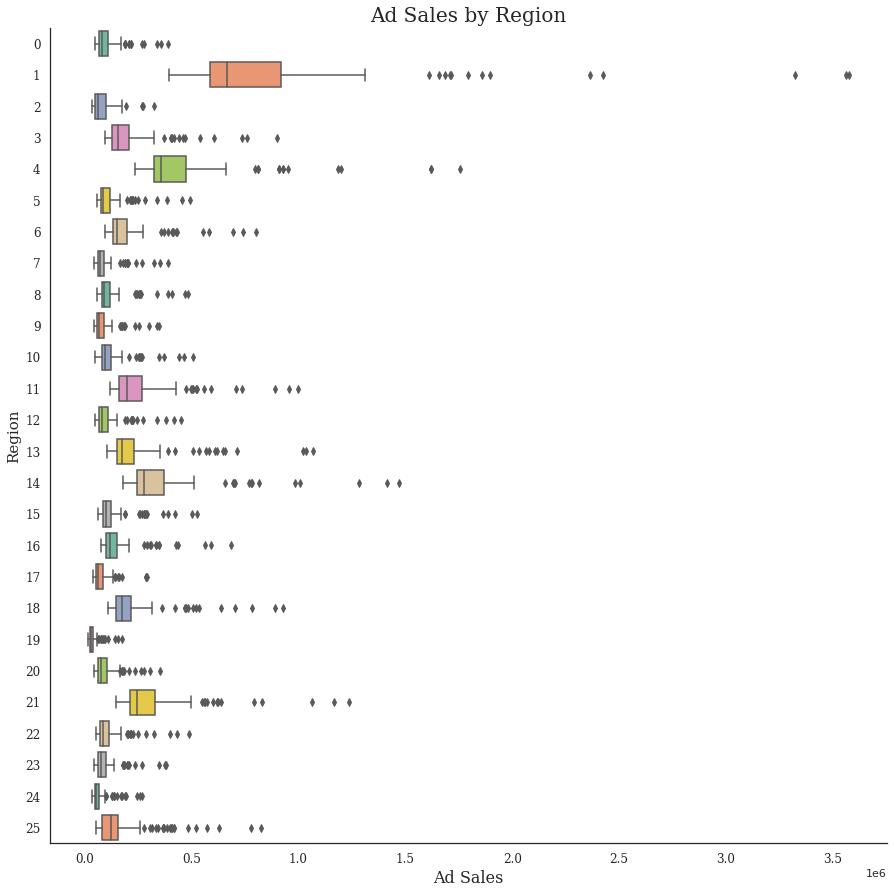

In [92]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style(style='white')
plt.yticks()
sns.boxplot(data=df, x = "Sales", y = "Division", orient="h", palette="Set2")
plt.ylabel("Region", fontsize = 15, fontname="serif")
plt.xlabel("Ad Sales", fontsize = 16, fontname="serif")
plt.title("Ad Sales by Region", fontsize = 20, fontname="serif")
plt.yticks(fontsize=12, fontname="serif")
plt.xticks(fontsize=12, fontname="serif")
sns.despine(right = True, top = True)
plt.savefig('gdrive/My Drive/sales_boxplot.png')

This figure demonstrates that ads showing in regions B, E, and O bring the most sales.

Total sales over time

In [14]:
sales_over_time = df.groupby(['Calendar_Week']).sum(['Sales']).reset_index(['Calendar_Week'])

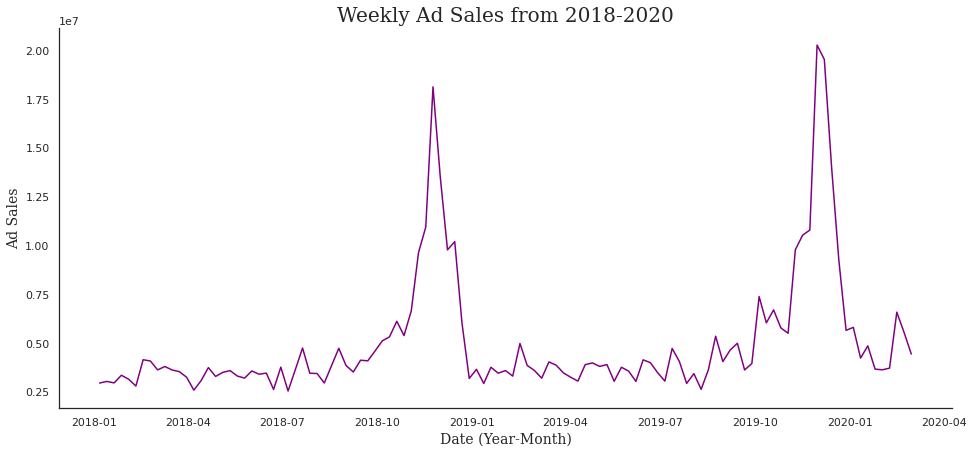

In [90]:
sales_over_time['Calendar_Week']= pd.to_datetime(sales_over_time['Calendar_Week'])

#Sort data
import numpy as np
order = np.argsort(sales_over_time['Calendar_Week'])
xs = np.array(sales_over_time['Calendar_Week'])[order]
ys = np.array(sales_over_time['Sales'])[order]

#Plot data
fig, ax = plt.subplots(figsize=(16, 7))

#n = 3  # Keeps every 5th week on x-axis
#[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.plot(xs, ys, color = 'purple')
ax.set_title('Weekly Ad Sales from 2018-2020',
              fontsize = 20,
              fontname="serif")
ax.set_ylabel('Ad Sales',
               fontsize=14,
               fontname = 'serif')
ax.set_xlabel('Date (Year-Month)', 
              fontsize=14,
               fontname = 'serif')
sns.despine(right = True, top = True)
fig.savefig('gdrive/My Drive/sales_lineplot.png')

The ad sales over time indicate a clear seasonal trend, especially between the months from October to January. We will discuss this more in detail when performing our time series forecasting.

# Build Machine Learning Models

In [150]:
# Extract month and year from date
df['Calendar_Week']= pd.to_datetime(df['Calendar_Week']) #Convert date variable to datetime
df['Month'] = df['Calendar_Week'].dt.month # Get month
df['Year'] = df['Calendar_Week'].dt.year # Get year
df = df.drop(columns =['Calendar_Week']) #Remove date time

# Data Preprocessing (Convert categorical items to numeric)
def Encoder(df):
          columnsToEncode = list(df.select_dtypes(include=['object']))
          le = LabelEncoder()
          for feature in columnsToEncode:
              try:
                  df[feature] = le.fit_transform(df[feature])
              except:
                  print('Error encoding '+feature)
          return df
df_preprocessed = Encoder(df)
df_preprocessed.head()

,Division,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales,Month,Year
0,0,392,422,408,349895.0107,73580,12072,682,59417,1,2018
1,0,787,904,110,506270.2176,11804,9499,853,56806,1,2018
2,0,81,970,742,430042.1538,52232,17048,759,48715,1,2018
3,0,25,575,65,417745.6658,78640,10207,942,72047,1,2018
4,0,565,284,295,408505.8012,40561,5834,658,56235,2,2018


In [151]:
# Train test split
y = df_preprocessed['Sales'] # target variable = ad sales
x = df_preprocessed.loc[:, ~df_preprocessed.columns.isin(['Sales'])] #explanatory variables are all other columns
y_binned = np.digitize(y, np.linspace(df_preprocessed['Sales'].min(), df_preprocessed['Sales'].max(), 100))
y_binned

array([2, 2, 1, ..., 4, 3, 3])

In [152]:
#Split data into training and testing set
x_train, x_test, y_train, y_test = scsplit(x, y, stratify = y_binned, random_state = 111) # split data. X is explanatory, and y is a target variable

#Scale data using StandardScaler()
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train) # scale training data
x_test_scaled = scaler.fit_transform(x_test) # scale testing data

# check length of X and Y
print(x.shape) 
print(y.shape)

(3051, 10)
(3051,)


In [153]:
linear = LinearRegression()
linear.fit(x_train_scaled, y_train)
linear.score(x_test_scaled, y_test)
print("Linear test score: {:.3f}".format(linear.score(x_test_scaled, y_test)))

Linear test score: 0.785


Most Significant Features

Division: -14770.94389260237
Paid_Views: 27446.010993891527
Organic_Views: 53876.41896048251
Google_Impressions: 48382.62021653513
Email_Impressions: 107338.20554545725
Facebook_Impressions: 71353.41384062747
Affiliate_Impressions: -10262.356652456678
Overall_Views: -83288.51108592696
Month: 30351.504994164432
Year: 1954.2956720442724


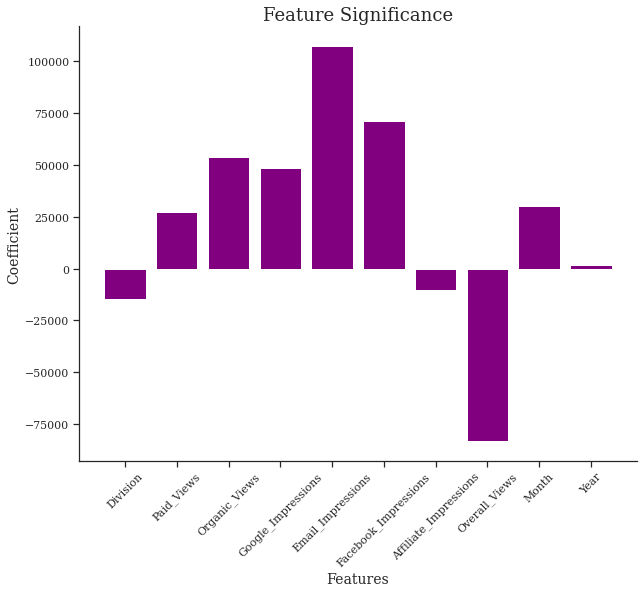

<Figure size 1080x1080 with 0 Axes>

In [121]:
df_features = df_preprocessed.drop('Sales', axis = 'columns')
important_features = linear.coef_
for i,v in enumerate(important_features):
 print(df_features.columns[i]+':',v)
plt.figure(figsize = (10, 8))
plt.bar([x for x in range(len(important_features))], important_features, color = 'purple')
plt.xticks(range(len(df_features.columns)), df_features.columns.to_list(), size='small', rotation=45)
plt.tick_params(bottom = True)
plt.tick_params(left = True)
plt.title('Feature Significance', fontsize = 18, fontname="serif")
plt.ylabel('Coefficient', fontsize = 14, fontname="serif")
plt.xlabel('Features', fontsize = 14, fontname="serif")
plt.yticks(fontsize=11, fontname="serif")
plt.xticks(fontsize=11, fontname="serif")
sns.despine(right = True, top = True)
plt.show()
plt.savefig('gdrive/My Drive/sales_feature_significance.png')

In [69]:
print(df_preprocessed.columns.to_list())

['Division', 'Paid_Views', 'Organic_Views', 'Google_Impressions', 'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions', 'Overall_Views', 'Sales', 'Month', 'Year']


## Random Forest Regression

In [122]:
# Create regressor object
rfr = RandomForestRegressor(random_state = 0)
  
# Fit the regressor with x and y data
rfr.fit(x_train_scaled, y_train)

## Random Searching for Gradient Boosting Regression ##
params = {'min_samples_leaf': np.arange(1, 60, 2),
          'n_estimators' : np.arange(10, 1000, 20),
          'max_depth'    : np.arange(2, 50, 2),
          'max_features': np.arange(1, 10, 1)
          }
search = RandomizedSearchCV(rfr, params, cv=5)
search.fit(x_train_scaled, y_train)

# extract best score and parameter by calling objects "best_score_" and "best_params_"
print("Random Forest optimal parameters: {}".format(search.best_params_))
print("Random Forest test score: {:.3f}".format(search.score(x_test_scaled, y_test)))

Random Forest optimal parameters: {'n_estimators': 890, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 20}
Random Forest test score: 0.883


## XGBoost

In [155]:
import warnings
warnings.filterwarnings("ignore")
xgbr = xgb.XGBRegressor()

## Random Searching for XGBoost ##
params = {'n_estimators' : np.arange(10, 1000, 20),
          'max_depth'    : np.arange(2, 50, 2),
          'learning_rate': [0.1, 0.01, 0.05]
          }
search = RandomizedSearchCV(xgbr, params, cv=5)
search.fit(x_train_scaled, y_train)
#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("XGBoost optimal parameters: {}".format(search.best_params_))
print("XGBoost test score: {:.3f}".format(search.score(x_test_scaled, y_test)))

[20:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

**Machine Learning Sales Prediction Summary Results:**
1. Linear Regression: 78.5%
2. Random Forest: 89.7%
3. XG Boost: 92.4%

# ARIMA Model



In [157]:
#Prepare the data for time series 
df = pd.read_csv('/content/gdrive/My Drive/media_spend.csv')
#Sum the sales for each division
df = df.groupby(['Calendar_Week']).sum(['Sales']).reset_index(['Calendar_Week'])
df['Calendar_Week'] = pd.to_datetime(df['Calendar_Week'])
df.sort_values(by='Calendar_Week', inplace = True) 
df.to_csv('media_spend_ts.csv')

In [158]:
#Convert time to index
df.set_index('Calendar_Week')

,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
Calendar_Week,,,,,,,,
2018-01-06,11247,11214,16934,1.846363e+07,3694309,995533,16447,2961900
2018-01-13,15453,12580,12548,2.670896e+07,626000,983495,17111,3043768
2018-01-20,12759,13145,14895,2.265773e+07,2304353,1234005,11919,2967530
2018-01-27,10709,15208,13324,2.204346e+07,3575722,814181,13857,3359958
2018-02-03,13416,15129,12932,2.154114e+07,2008599,636301,16783,3156423
...,...,...,...,...,...,...,...,...
2020-02-01,1173102,958532,26905596,5.259952e+07,1899509,452385,2122081,3637978
2020-02-08,1114954,1015916,27657456,1.926289e+07,7646633,396513,2118864,3723924
2020-02-15,1047385,1199619,19928546,1.523839e+07,13503012,438225,2240520,6589887


###1. Check the stationarity assumption

In [159]:
# Check for stationarity w/test (Null assumes non-stationarity)
def adtest_results(data):
  dftest = adfuller(data, autolag = 'AIC')
  print("ADF: ", dftest[0])
  print("P-Value: ", dftest[1])
adtest_results(df['Sales']) # p-value shows indication of stationarity

ADF:  -3.1149859001738234
P-Value:  0.02546385964850048


The line plot shows that there is not upward/downward trend for our variable of interest, sales, over time. Furthermore, the p-value of the Augmented Dickey Fuller test shows significance at the 0.05 level, which shows that we can reject the null of no stationarity. Particularly, there is no presence of a unit root. Still, we should check to see if there is a different form of non-stationarity present in the series.

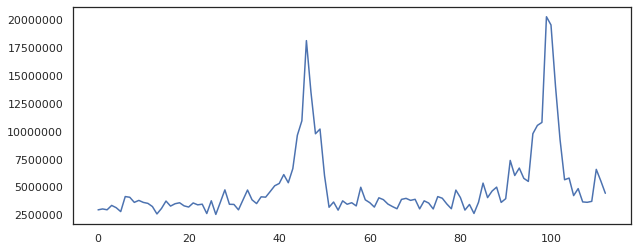

In [98]:
# Check for Stationarity w/graph
plt.ticklabel_format(style='plain')
df['Sales'].plot(use_index=False, figsize = (10,4))

We see that there is a clear indication of seasonality in our series. Particularly, there are sale shocks that occur between the end to the very beginning of the year (from Oct to Jan). Thus, there is an indication of non-stationarity.

### 2. Check for ACF and PACF for Autocorrelation and Moving Averages

<Figure size 288x144 with 0 Axes>

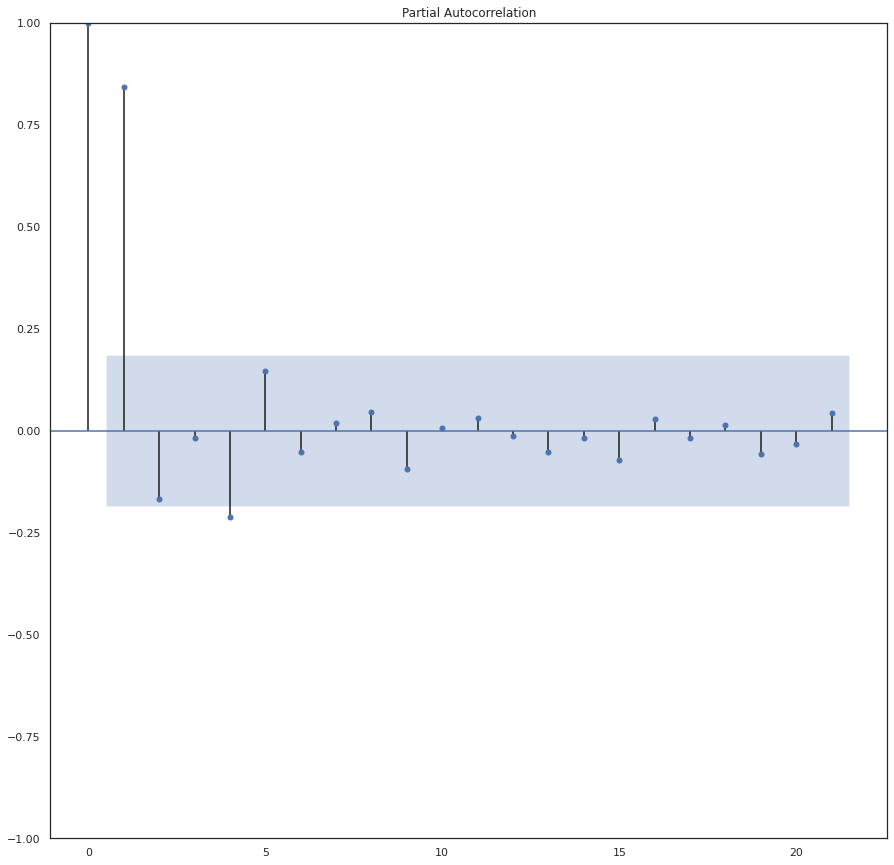

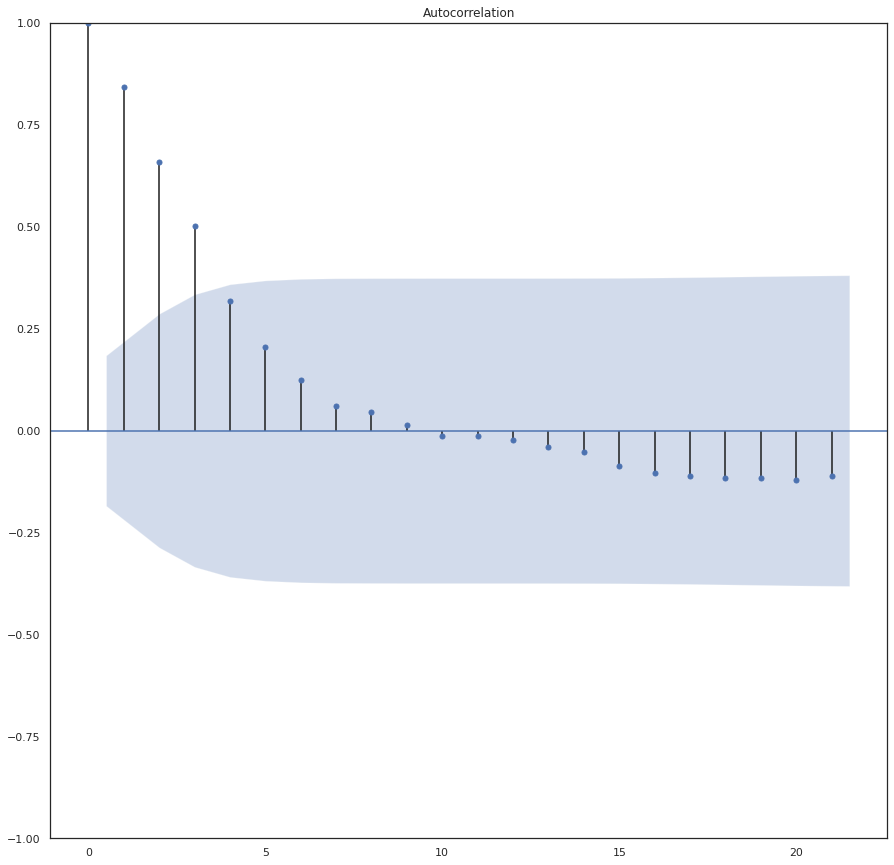

In [99]:
plt.figure(figsize = (4,2))
plot_pacf(df.Sales)
plot_acf(df.Sales);

The partial autocorrelation graph for sales shows that the current value is most strongly correlated with its first lag. It is also correlated with its 4th, but very slightly. Thus, it may not be necessary to include moving averages into our model.

The ACF plot starts off with a geometric decay, with a statistically significant correlation with a current value up to its first few lags. Additionally, the sinosoidal decay demonstrates the seasonality we saw in the time trand. This non-stationarity may mean that differencing is appropriate in our case.

## 3. Auto-fit the SARIMA (0,1,0) Model

In [100]:
#Total number of weeks
len(df)

113

In [160]:
# Split data into training and testing

# Sales
y_train = df.iloc[:84, 8] #85 points in training data
y_test = df.iloc[84:, 8] 

# Dates
x_train = df.iloc[:84, 0] #28 points in testing data
x_test = df.iloc[84:, 0] 

In [161]:
sarima_model = auto_arima(y = y_train,
                         x = x_train,
                         m = 52, #52 data points per year
                         random_state = 0)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   84
Model:             SARIMAX(0, 1, 0, 52)   Log Likelihood                -464.879
Date:                  Sat, 18 Feb 2023   AIC                            933.758
Time:                          20:44:19   BIC                            936.689
Sample:                               0   HQIC                           934.729
                                   - 84                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.255e+05   8.77e+04      2.573      0.010    5.37e+04    3.97e+05
sigma2      2.432e+11   7.21e+10      3.374      0.001    1.02e+11    3.84e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.67   Prob(JB):                         0.78
Heteroskedasticity (H):               2.20   Skew:                             0.13
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. Predict and Plot Predictions

In [174]:
# Predict on test set
forecast=sarima_model.predict(n_periods=len(x_test))

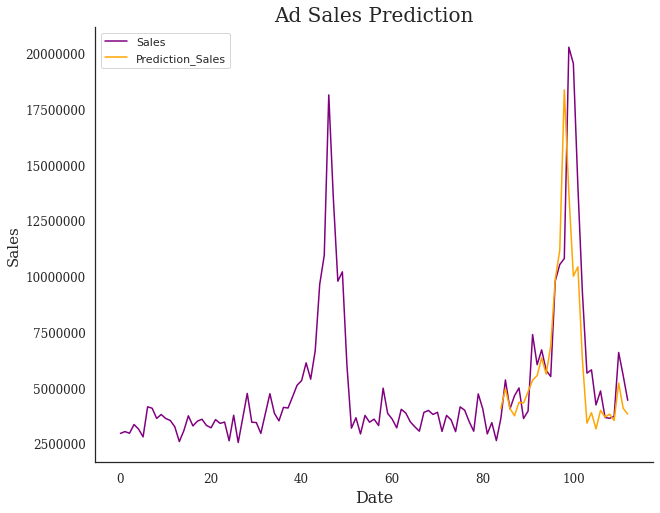

In [165]:
# Plot prediction
plt.figure(figsize = (10,8))
df['Sales'].plot(use_index=False, legend = True, color = 'purple')
forecast.plot(legend = True, label = 'Prediction_Sales', color = 'orange')
plt.ticklabel_format(style='plain')
plt.ylabel("Sales", fontsize = 15, fontname="serif")
plt.xlabel("Date", fontsize = 16, fontname="serif")
plt.title("Ad Sales Prediction", fontsize = 20, fontname="serif")
plt.yticks(fontsize=12, fontname="serif")
plt.xticks(fontsize=12, fontname="serif")
sns.despine(right = True, top = True)
plt.savefig('gdrive/My Drive/sarima.png')